In [1]:
import matplotlib.pyplot as plt
from matplotlib import style
style.use('plotting.mplstyle')
import numpy as np
import pandas as pd
import seaborn as sns
cp=sns.color_palette('Dark2', 20)
from scipy.stats import gaussian_kde
import json

**Warning**: This script assumes that you have cloned the repository hosting data for Galaudage+ 2021 (ApJL 921, L15): https://github.com/shanikagalaudage/bbh_spin


Specifically, it assumes that a link to this repository has been created in the following location:

```bash
../code/input/galaudage-data
```

If you have *not* cloned this repository, do the following (replace brackets with actual filepaths):

```bash
$ cd [...desired location...]
$ git clone git@github.com:shanikagalaudage/bbh_spin.git
$ cd [...gwtc3-spin-studies repository]/code/input/
$ ln -s [...path to bbh_spin] galaudage-data
```

**Warning #2**: This script also assumes that the notebook `make_figure_01.ipynb` has been run, generating a file called `SD_Bayes.json`.

### Make lefthand panel of figure 12

In [2]:
# Read in pickled posterior samples from Galaudage+
posts = pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_1.pkl.bz2") \
    + pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_2.pkl.bz2")
posts_zero = pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_zero_1.pkl.bz2") \
    + pd.read_pickle("../code/input/galaudage-data/posterior_samples/posteriors_zero_2.pkl.bz2")

event_ids = []
ff = open("../code/input/galaudage-data/posterior_samples/event_list.txt","r")
for line in ff.read().splitlines():
    event_ids.append(line)

In [3]:
# dict to hold nested sampling p_spinning and bayes factor values for each event
NestedSampling_dict = {}

for i,event in enumerate(event_ids):
    
    ln_ev = posts_zero[i].ln_evidence.values[0]-posts[i].ln_evidence.values[0]
    
    BF = np.exp(ln_ev)
    p_nonspinning = BF/(1+BF)

    NestedSampling_dict[event] = {'BF':BF, 'p_nonspinning': p_nonspinning}

In [4]:
# dict to hold savage dickey p_spinning values and bayes factors for each event
with open("SD_bayes.json","r") as jf:
    bayesDictionary = json.load(jf)

SD_bayes_results = np.array(bayesDictionary['chiMax_1.0'])

SD_dict = {}
for j,event in enumerate(event_ids):
    BF = SD_bayes_results[j]
    p_nonspinning = BF/(1+BF) 
    SD_dict[event] = {'BF':BF, 'p_nonspinning': p_nonspinning}

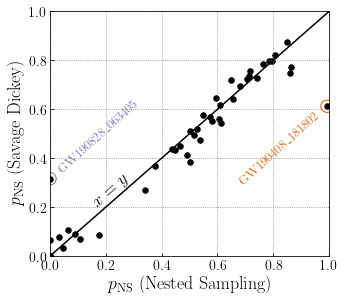

In [30]:
# make figure
fig = plt.figure(figsize=(5,4.5))
plt.style.use('plotting.mplstyle')
NestedSampling_pnonspinning = np.asarray([NestedSampling_dict[event]['p_nonspinning'] for event in NestedSampling_dict])
SD_pnonspinning = np.asarray([SD_dict[event]['p_nonspinning'] for event in SD_dict])
                          
plt.scatter(NestedSampling_pnonspinning, SD_pnonspinning,s=30,c='k')
imax=np.argmax(NestedSampling_pnonspinning)

plt.scatter(NestedSampling_pnonspinning[imax],SD_pnonspinning[imax],s=150, facecolors='none', edgecolors=cp[1])

plt.scatter(NestedSampling_dict['GW190828\_063405']['p_nonspinning'],SD_dict['GW190828\_063405']['p_nonspinning'],
            s=150, facecolors='none', edgecolors=cp[2])

plt.text(0.67,0.29,'GW190408\_181802',c=cp[1],fontsize=13,rotation=42)
plt.text(0.02,0.34,'GW190828\_063405',c=cp[2],fontsize=13,rotation=42)

plt.plot(np.linspace(0,1,10), np.linspace(0,1,10), color='k')
plt.text(0.14,0.20,'$x=y$',rotation=42,fontsize=18)
plt.xlabel(r'$p_{\mathrm{NS}}$ (Nested Sampling)')
plt.ylabel(r'$p_{\mathrm{NS}}$ (Savage Dickey)')
plt.xlim(0,1)
plt.ylim(0,1)
plt.show()
fig.savefig("figure_12a.pdf",bbox_inches='tight')  

### Make center panel of figure 12

In [6]:
# Load sampleDict
sampleDict = np.load("../code/input/sampleDict_FAR_1_in_1_yr.pickle", allow_pickle=True)
GW190408_chi1_chi2_posteriors = [sampleDict['S190408an']['a1'], sampleDict['S190408an']['a2']]

*c* argument looks like a single numeric RGB or RGBA sequence, which should be avoided as value-mapping will have precedence in case its length matches with *x* & *y*.  Please use the *color* keyword-argument or provide a 2D array with a single row if you intend to specify the same RGB or RGBA value for all points.


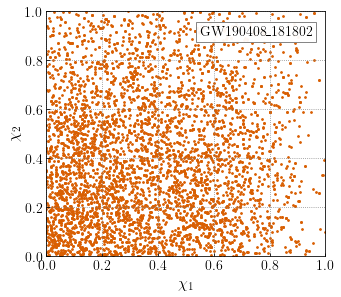

In [52]:
# make figure
idxs = np.random.choice(np.arange(len(GW190408_chi1_chi2_posteriors[0])), replace=False, size=5000)
fig = plt.figure(figsize=(5,4.5))
plt.scatter(GW190408_chi1_chi2_posteriors[0][idxs], GW190408_chi1_chi2_posteriors[1][idxs], s=3, c=cp[1])
plt.xlabel(r'$\chi_1$', fontsize=16)
plt.ylabel(r'$\chi_2$', fontsize=16)
plt.xlim(0,1)
plt.ylim(0,1)
plt.text(0.55,0.915,r'GW190408\_181802',c='k',fontsize=14,
         bbox=dict(boxstyle="square",alpha=0.95, fc="w", ec="0.5"), va='center')
plt.show()
fig.savefig("figure_12b.pdf",bbox_inches='tight') 

### Maker right-hand panel of figure 12

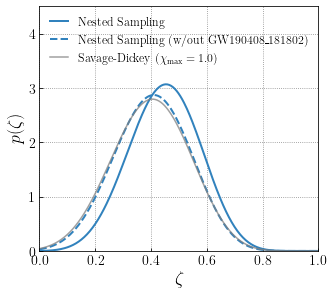

In [55]:
# Using our non-spinning vs. spinning Bayes factors above, we can compute the analytic
# posterior on the fraction of non-spinning systems

# Instantiate an array of possible zero-spin fractions
fs = np.linspace(0,1,300)

# Instantiate arrays to hold p(f) computed three ways:
# - With Savage-Dickey Bayes factor estimates (SD)
# - With nested sampling evidence ratios (NS)
# - With nested sampling, excluding GW190408
p_fs_SD = np.zeros_like(fs)
p_fs_NS = np.zeros_like(fs)
p_fs_NS_excluding_190408 = np.zeros_like(fs)

# Get sets of Bayes factors
SD_bayes = np.asarray([SD_dict[event]['BF'] for event in SD_dict])
NS_bayes = np.asarray([NestedSampling_dict[event]['BF'] for event in NestedSampling_dict])

index_190408 = event_ids.index('GW190408\\_181802')
NS_bayes_excluding_190408 = np.delete(NS_bayes,index_190408)

for i,f in enumerate(fs):
    p_fs_SD[i] = np.prod(SD_bayes*f  + (1.-f))
    p_fs_NS[i] = np.prod(NS_bayes*f  + (1.-f))
    p_fs_NS_excluding_190408[i] = np.prod(NS_bayes_excluding_190408*f  + (1.-f))
    
# Plot!
fig,ax = plt.subplots(figsize=(5,4.5))

ax.plot(fs,p_fs_NS/np.trapz(p_fs_NS,fs),color='#3182bd',label='Nested Sampling',lw=2)
ax.plot(fs,p_fs_NS_excluding_190408/np.trapz(p_fs_NS_excluding_190408,fs),color='#3182bd',ls='--',
        label='Nested Sampling (w/out GW190408\\_181802)',lw=2)
ax.plot(fs,p_fs_SD/np.trapz(p_fs_SD,fs),color='grey',label='Savage-Dickey ($\chi_\mathrm{max} = 1.0$)',alpha=0.75)

ax.set_xlim(0,1)
ax.set_ylim(0,4.5)
ax.set_xlabel("$\zeta$")
ax.set_ylabel("$p(\zeta)$")
ax.legend(loc='upper right',fontsize=12,handlelength=1.5)

plt.savefig('figure_12c.pdf',bbox_inches='tight')
plt.show()